In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd

In [40]:
import datetime

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from sqlalchemy import func

In [42]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [44]:
# We can view all of the classes that automap found
tables = Base.classes.keys()

In [45]:
#Print all the tables and their columns
inspector = inspect(engine)
for i in tables:
    print(i)
    print("----")
    for j in inspector.get_columns(i):
        print(j['name'],j['type'])
    print("")

measurement
----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [46]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
date_format = '%Y-%m-%d'
# Calculate the date 1 year ago from the last data point in the database
search_date = datetime.datetime.strptime(latest_date, date_format) - pd.DateOffset(years=1)
search_date = search_date.strftime(date_format)
# Perform a query to retrieve the data and precipitation scores
search = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > search_date).statement
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(search,session.bind,index_col='date').sort_index()
df = df.dropna()

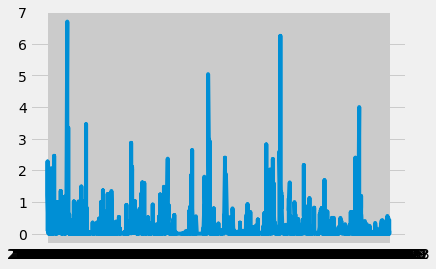

In [49]:
# Use Pandas Plotting with Matplotlib to plot the data
###CLEAN THIS GRAPH UP
plt.plot(df['prcp'])

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [51]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station.distinct()).count()
num_stations

9

In [52]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc())
most_active = station_count.first()[0]
station_count.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temps = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active)
most_active_temps.all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [54]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_stmt = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date > search_date).filter(Measurement.station == most_active).statement
temp_df = pd.read_sql(temp_stmt,session.bind,index_col='date').sort_index().dropna()


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

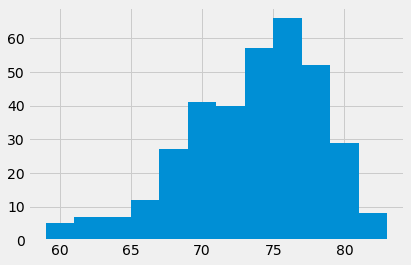

In [55]:
plt.hist(temp_df['tobs'],bins=12)

## Bonus Challenge Assignment

In [56]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [72]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tstats = calc_temps(search_date, latest_date)[0]

In [77]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(tstats)

TypeError: bar() missing 1 required positional argument: 'height'

In [59]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [60]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [61]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [62]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [63]:
# Plot the daily normals as an area plot with `stacked=False`
